# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Ваша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

### Шаг 1. Откройте файл с данными и изучите общую информацию. 

In [1]:
# весь этот кусок скрипта срабатывает с третьего раза без предупреждений))) 
# пока не получилось разобраться, почему, и где именно проблемы

import pandas as pd
# импортируем библиотеку pandas, она хорошая
pd.options.display.max_columns = None
# это, чтобы видеть все колонки. Спасибо Slack :)

data = pd.read_csv('/datasets/real_estate_data.csv', sep = '\t')
# читаем исходник с учётом разделителя в виде слэша+t
data.head()
# смотрим шапочку загруженного датасета
data.info()
# смотрим данные по типам и объемам данных в нашем сете

data['locality_name'].value_counts().head(10)
# смотрим на список уникальных населённых пунктов
(data[data['locality_name']
      .str.lower()
      .str.contains(
          ('санкт-петербург|спб|питер|мурино|шушары|всеволожск|пушкин|колпино|парголово|гатчина|кудрово|выборг'))
          == True]
     ['locality_name']
     .unique()
)
# здесь мы ищем в столбце с геоназваниями ключевые слова из топ-10 населённых пунктов, 
# предварительно уменьшив регистр на всякий пожарный, и выводим уникальные названия
data['locality_name'].loc[data['locality_name'].isin(['поселок Мурино', 'Мурино'])] = 'посёлок Мурино'
data['locality_name'].loc[data['locality_name'] == 'Кудрово'] = 'деревня Кудрово'
data['locality_name'].value_counts().head(10)
# заменили названия одинаковых населённых пунктов на одинаковые, проверяем статистику топ-10, 
# изменилось ли количество

pd.DataFrame([data.min(), data.max()], index = ('min_value', 'max_value'))
# смотрим на максимальные и минимальные значения в столбцах, мало ли что там обнаружится

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
# в гуглах говорят, что эти команды помогают показать все результаты работы скрипта, а не только последний. Поверим.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
total_images            23699 non-null int64
last_price              23699 non-null float64
total_area              23699 non-null float64
first_day_exposition    23699 non-null object
rooms                   23699 non-null int64
ceiling_height          14504 non-null float64
floors_total            23613 non-null float64
living_area             21796 non-null float64
floor                   23699 non-null int64
is_apartment            2775 non-null object
studio                  23699 non-null bool
open_plan               23699 non-null bool
kitchen_area            21421 non-null float64
balcony                 12180 non-null float64
locality_name           23650 non-null object
airports_nearest        18157 non-null float64
cityCenters_nearest     18180 non-null float64
parks_around3000        18181 non-null float64
parks_nearest           8079 non-null float64
ponds_around300

/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


### Изучаем то, что нам дано

#### Первый взгляд
Взглянуть не получилось, потому что все данные слепились в одну строчку. Это вызвано тем, что там разделитель не запятая, как обычно в csv, а одинарный обратный слэш + буква "t". Поправлю это недоразумение, загружу датасет с учётом разделителя. 

#### Второй первый взгляд

Очень интересный датасет!
- Вижу много пропусков. С каждым столбцом будем разбираться отдельно, определять, где логичнее убрать совсем строки с пропусками, где можно было бы заменить на среднее/медиану/значение по умолчанию, а где вообще оставить их в покое
    
#### Текстовые значения
Долг обязывает посмотреть, что скрывается в столбцах типа object. "first_day_exposition" сейчас трогать не будем, он покажет нам ошибку (аномалию), если не получится преобразовать в тип дата-время. То же самое для перевода столбца "is_apartment" в булев тип. Остались населённые пункты. Нас будет интересовать топ-10 по объялениям и самый крупный из них - СПб. Поищем, нет ли среди названий тех же населённых пунктов, что и в топе, но написанных как-то иначе. Нашлось три варианта Мурино и два варианта Кудрово. Заменю их на одинаковое написание и перезапишу в исходную переменную.

Ну вот, теперь не потеряем ни одного Мурино и Кудрово. После объединения всех "Кудровских" объявлений даже поменялся порядок в рейтинге! Значит, сделали важную обработочку.

#### Min-max значения, выбросы, беглый взгляд
- Из всех столбцов сразу бросается в глаза столбце с высотой потолка, высота 1 или 100 метров не очень правдоподобна.
- Жилплощадь в 2 метра - это грустно, но наверное и такое может быть. Как и кухня в 1,3 кв. метра.
- Нулевое расстояние в метрах до аэропорта, скорее всего, означает, что данных нет. Даже если бы это были апартаменты при аэропорте, было бы хоть сколько-нибудь метров.
- 1 метр до парка, хмм.. Допустимо, если конец дома - это конец его кадастровой территории, например.

Дальше надо осторожно заняться пропусками.



### Шаг 2. Предобработка данных

In [2]:
import matplotlib.pyplot as plt
# импортируем графичную библиотеку на будущее, пока я не забыла


# I. NaNы

# 1) работаем с высотой потолков:

data['ceiling_height'].describe()
data.query('6 >= ceiling_height >= 1.8')['ceiling_height'].describe()
# сравниваем статистические параметры наших данных с выбросами и без
data_na_handled = data.copy()
data_na_handled['ceiling_height'] = data['ceiling_height'].fillna(data['ceiling_height'].median()) 
# заменим пропуски на медианы и запишем в новую переменную
data_na_handled['ceiling_height'].isna().sum()
# проверяем, не осталось ли пропусков

# 2) работаем с количеством этажей:

data_na_handled = data_na_handled.dropna(subset = ['floors_total'])
# UPD: удаляем из всего датасета строки, где пропущено количество этажей

# 3) работаем с жилплощадью и площадью кухни:

data_na_handled[data_na_handled['living_area'].isna()].head()
# выведем шапку таблицы, где нет жилплощади
data_na_handled[data_na_handled['kitchen_area'].isna()].head()
# выведем шапку таблицы, где нет площади кухни

# 4) работаем с "апартаментностью":

data_na_handled['is_apartment'].value_counts()
data_na_handled['is_apartment'] = data_na_handled['is_apartment'].fillna(False)
data_na_handled['is_apartment'].value_counts()

# 5) работаем с балконами:

data_na_handled['balcony'] = data_na_handled['balcony'].fillna(0)
data_na_handled['balcony'].isna().sum()
# заменяем пропуски на нули и проверяем наличие пропусков после преобразования

# 6) работаем с географическими наименованиями:

data_na_handled = data_na_handled.dropna(subset = ['locality_name'])
# UPD: удаляем из всего датасета строки, где пропущен населённый пункт

# 7) работаем с картографией:

len(data_na_handled.query('(cityCenters_nearest.isnull()) and (locality_name == "Санкт-Петербург")'))
# смотрим, есть ли у нас квартиры в СПб, где не указано расстояние до центра
len(data_na_handled.query('locality_name == "Санкт-Петербург"'))
# смотрим, сколько у нас квартир в Питере вообще
(len(data_na_handled
     .query('(cityCenters_nearest.isnull()) and (locality_name == "Санкт-Петербург")'))
     /len(data_na_handled
     .query('locality_name == "Санкт-Петербург"'))
     * 100) 
# Какова доля в процентах тех квартир, что не имеют данных по расстоянию до центра?

# 8) работаем с длительностью размещения объявления:

# На заметку: дата оформления объявления изначально у нас записана так: 2015-07-24T00:00:00

data_na_handled['first_day_exposition'] = pd.to_datetime(data_na_handled['first_day_exposition'], format = '%Y-%m-%dT%H:%M:%S')
# совмещаем полезное с полезным, переводим даты-строки в даты-даты. 
len(data_na_handled.query('(days_exposition.isnull()) and (first_day_exposition.dt.year >= 2018)'))
# ищем, сколько объявлений без длительности размещения относятся к 2018 году и позже

# II. Типы данных.

col_list = ['balcony', 'floors_total', 'last_price', 'days_exposition', 'parks_around3000', 'ponds_around3000'] # выделяешь список признаков, которые хочешь сконвертировать в int

for col in col_list:

# далее бежим по этим признакам в датафрейме handled и либо конвертируем тип обычным astype, а если не получится, то через round

    try:

        data_na_handled[col] = data_na_handled[col].astype('Int64')

    except:

        data_na_handled[col] = data_na_handled[col].round(0).astype('Int64')

data_na_handled['is_apartment']=data_na_handled['is_apartment'].astype('bool')
data_na_handled.info()
# Перевели различные колонки в логичные для них типы данных

count    14504.000000
mean         2.771499
std          1.261056
min          1.000000
25%          2.520000
50%          2.650000
75%          2.800000
max        100.000000
Name: ceiling_height, dtype: float64

count    14472.000000
mean         2.726794
std          0.278705
min          2.000000
25%          2.510000
50%          2.650000
75%          2.800000
max          6.000000
Name: ceiling_height, dtype: float64

0

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,2.65,14.0,NaN,9,NaN,False,False,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
7,5,7915000.0,71.6,2019-04-18T00:00:00,2,2.65,24.0,NaN,22,NaN,False,False,18.9,2.0,Санкт-Петербург,23982.0,11634.0,0.0,NaN,0.0,NaN,NaN
30,12,2200000.0,32.8,2018-02-19T00:00:00,1,2.65,9.0,NaN,2,NaN,False,False,NaN,NaN,Коммунар,NaN,NaN,NaN,NaN,NaN,NaN,63.0
37,10,1990000.0,45.8,2017-10-28T00:00:00,2,2.50,5.0,NaN,1,NaN,False,False,NaN,NaN,поселок городского типа Красный Бор,NaN,NaN,NaN,NaN,NaN,NaN,196.0
44,13,5350000.0,40.0,2018-11-18T00:00:00,1,2.65,22.0,NaN,3,NaN,False,False,NaN,1.0,Санкт-Петербург,30471.0,11603.0,1.0,620.0,1.0,1152.0,NaN


,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,2.65,14.0,NaN,9,NaN,False,False,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
30,12,2200000.0,32.8,2018-02-19T00:00:00,1,2.65,9.0,NaN,2,NaN,False,False,NaN,NaN,Коммунар,NaN,NaN,NaN,NaN,NaN,NaN,63.0
37,10,1990000.0,45.8,2017-10-28T00:00:00,2,2.50,5.0,NaN,1,NaN,False,False,NaN,NaN,поселок городского типа Красный Бор,NaN,NaN,NaN,NaN,NaN,NaN,196.0
44,13,5350000.0,40.0,2018-11-18T00:00:00,1,2.65,22.0,NaN,3,NaN,False,False,NaN,1.0,Санкт-Петербург,30471.0,11603.0,1.0,620.0,1.0,1152.0,NaN
59,15,6300000.0,46.5,2017-03-06T00:00:00,1,2.65,13.0,NaN,13,NaN,False,False,NaN,NaN,Санкт-Петербург,11125.0,14501.0,0.0,NaN,0.0,NaN,336.0


False    2725
True       50
Name: is_apartment, dtype: int64

False    23563
True        50
Name: is_apartment, dtype: int64

0

60

15651

0.3833620854897451

2745

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23565 entries, 0 to 23698
Data columns (total 22 columns):
total_images            23565 non-null int64
last_price              23565 non-null Int64
total_area              23565 non-null float64
first_day_exposition    23565 non-null datetime64[ns]
rooms                   23565 non-null int64
ceiling_height          23565 non-null float64
floors_total            23565 non-null Int64
living_area             21700 non-null float64
floor                   23565 non-null int64
is_apartment            23565 non-null bool
studio                  23565 non-null bool
open_plan               23565 non-null bool
kitchen_area            21343 non-null float64
balcony                 23565 non-null Int64
locality_name           23565 non-null object
airports_nearest        18041 non-null float64
cityCenters_nearest     18064 non-null float64
parks_around3000        18065 non-null Int64
parks_nearest           8030 non-null float64
ponds_around3000

#### Изучаем NaNы

##### Высота потолков

Высота потолков указана в 14504 из 23699 объявлений. Действительно, не всегда указывается высота потолков, если объявление краткое, есть более приоритетные характеристики. Но, так как это весомый ценообразущий параметр в нашей задаче, всё довольно прискорбно. Да ещё и разброс значений вызывает подозрения (от 1 до 100!). Посмотрим, какая медиана получается при наличии выбросов и при из отсутствии. Ага, вроде бы одинаковые значения, чего не скажешь о среднем. Заменим многочисленные пропуски на медиану. С выбросами разберёмся потом. 


##### Количество этажей

86 пропущенных значений в датасете, взглянем, что это за объявления. Может быть, не было такого параметра при описании квартиры, когда эти 86 продавцов публиковали объявления. В этих объявлениях имеется номер этажа, но мы не сможем определить из этих данных, сколько же там всего этажей, а эта информация бы нам пригодилась в категоризации данных на первый, последний и остальные этажи. Ничего вроде среднего/медианы подставить мы туда тоже не можем, иначе может получиться, например, что кто-то жил на 14 этаже пятиэтажки. Оставим в покое эти пропуски, выжмем из них хотя бы номер этажа, когда придёт время. 

##### Жилплощадь и площадь кухни

1903 пропуска значений жилой площади и 2278 пропусков площади кухни. Не те ли это значения, где у нас продаются апартаменты? Нет, похоже, что тут зависимости нет. Вообще, странно, что этих данных нет, они довольно стандартные для описаний квартир и могут влиять на принятие решения о покупке. Могу предположить разве что, что некоторые объявления были взяты из источников, где этот параметр по умолчанию не заполняется, вот продавец и не заполнил. То же самое для площади кухни, решили что общей площади достаточно для продажи квартиры. В любом случае, в проекте требуется вычислить отношения этих площадей к общей, дальше параметры и их отношения не упоминаются. То есть для высокой статистики и резюмирования они не понадобятся, оставлю эти наны в покое, посчитаю отношения там, где это возможно.

##### Апартаменты иль нет

Из 2775 ненулевых значений апартаментов только 50 штук. Почему вообще так мало этих данных? Скорее всего, потому что при продаже квартиры этот параметр даже не подразумевается, так как апартаменты формально - это не квартира, хоть и выглядит, как квартира. 
По умолчанию будем считать, что там, где у нас этих данных нет, размещены объявления об обычной квартире, и заменим пропуски на False. 

##### Балконы

Большое спасибо за подсказку в задании! Заменим пропуски на 0. Действительно, если балкона вовсе нет, зачем вносить про него данные?

##### Населённый пункт

У нас есть 49 квартир неизвестно, где. Очень заманчивая сделка! Можно было бы запустить полномасштабное исследование, какие города и посёлки могли бы подойти под оставшиеся в живых параметры. Например, судя по расстоянию до аэропорта и центра города, многие из этих квартир скорее всего питерские. Возможно, в этом разгадка отсутствия значений: люди из крупных городов забывают, что есть жизнь и за (М)КАДом, и просто не указывают свой мегаполис. Но гарантии нет, оставляем пропуски как есть, в интересующие нас срезы они не попадут.

##### Картографические данные

Из всех имеющихся картографических параметров в исследовании нам понадобится только расстояние до центра, и то в Питере. Поэтому все пустые ячейки в этих столбцах, кроме расстояния до центра, я оставлю пустовать.
Посмотрим, есть ли пропуски в колонке расстояния до центра именно для Санкт-Петербурга. Есть 61 квартира без этих данных, это 0.4% от всех квартир в СПб. Несущественно, мы оставим эти пропуски за кадром при отборе данных для Питера.

##### Длительность размещения объявления

Имеется примерно 3к пропусков. Из них подавляющее большинство относится к объявлениям 2018 года и моложе. Имея максимальное время продажи (допускаем его из длительности размещения объявления), близкое к 4.5 годам, напрашивается простое объяснение этим пропускам: на момент выкачки данных эти квартиры были ещё в продаже. Приняв такое объяснение, мы не будем жалеть об этих строчках, так из них невозможно получить информацию о скорости продажи квартир. 
п.с. Отвечая на вопрос о происхождении пропусков, заодно и перевела тип данных с датой размещения в нужный. Перейдём тогда и к остальным преобразованиям типов.

#### Меняем типы данных

В табличке жирным выделены те колонки, типы данных в которых в итоге я решила поменять, с учётом всех нюансов. Включая оценку трудозатрат при работе с пропущенными значениями, без которой невозможно перевести в целочисленный тип: где-то, по моим оценкам, оказалось менее трудозатратно оставить NaNы и вещественный тип, потому что можно всё это учесть в следующих шагах, работая со срезами.

колонка | комментарии
:---- | :----
airports_nearest | вещественный, оставим так
**balcony** | вещественный, обидно и опасно иметь полтора балкона, поменяем на целочисленный
ceiling_height | здесь каждый сантиметр важен, оставляем вещественный
cityCenters_nearest | вещественный, оставим так
**UPD: days_exposition** | **вещественный, поменяем на int**
**first_day_exposition** | перезаписали в тип дата-время
floor | нормальный такой целочисленный тип
**floors_total** | а вот тут недоработка, чтобы не пугать недостроем на треть этажа, сделаем целочисленным сей тип - запомним, что пропуски были заменены на нули ради этого. Нулеэтажных домов всё равно не бывает.
**is_apartment** | предполагается, что это булев тип, сделаем его таковым
kitchen_area | это болезненный момент, каждый сантиметр важен, оставляем вещественный
**UPD: last_price** | **меняем на цену в целых рублях**
living_area | вещественный, и это очень хорошо
locality_name | это мы в число не превратим, пусть останется object
open_plan | булев тип, так нам и надо
**UPD: parks_around3000** | **число парков должно быть целым, поменяем тип**
parks_nearest | вещественный, оставим так
**UPD: ponds_around3000** | **число водоёмов должно быть целым, поменяем тип**
ponds_nearest | вещественный, оставим так
rooms | закончились шутки про половинные объекты, здесь всё ок, целые числа
studio | да, булев тип, пан или пропал
total_area | эти сантиметры решают судьбы людей, вещественный тип
total_images | нормально, целые числа



Пришло время для некоторых калькуляций, необходимых для ответов на вопросы жизни, вселенной и всего такого.

In [3]:
data_na_handled.isnull().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height              0
floors_total                0
living_area              1865
floor                       0
is_apartment                0
studio                      0
open_plan                   0
kitchen_area             2222
balcony                     0
locality_name               0
airports_nearest         5524
cityCenters_nearest      5501
parks_around3000         5500
parks_nearest           15535
ponds_around3000         5500
ponds_nearest           14529
days_exposition          3171
dtype: int64

### Шаг 3. Посчитайте и добавьте в таблицу

In [4]:
import numpy as np
# качнём математическую библиотечку, пригодится

data_na_handled['sq_meter_price'] = data_na_handled['last_price'] / data_na_handled['total_area']
data_na_handled['sq_meter_price']=data_na_handled['sq_meter_price'].astype('int64')
data_na_handled['last_price']=data_na_handled['last_price'].astype('int64')
data_na_handled['weekday_exposition'] = data_na_handled['first_day_exposition'].dt.weekday
data_na_handled['month_exposition'] = data_na_handled['first_day_exposition'].dt.month
data_na_handled['year_exposition'] = data_na_handled['first_day_exposition'].dt.year
# посчитали и добавили в новые столбцы:
#    - цена за кв. метр
#    - день недели, когда разместили объявление
#    - месяц, когда разместили объявление
#    - год размещения объявления

result = []
def floor_category(floor, floors_total):
    if floor == 1:
        result = 'первый'
    elif floor == floors_total:
        result = 'последний'
    else:
        result = 'другой'
    return result
# эта функция категоризирует этажи на три вида: первый, последний, другие
# при этом она учитывает, что мы ранее заменили NaNы в колонке с кол-вом этаже на нули (чтобы перевести в int64)
# и такие строки с нулём этаже не категоризируются, в результате выводится NaN

data_na_handled['floors_category'] = data_na_handled.apply(lambda row: floor_category(row['floor'], row['floors_total']), axis = 1)
data_na_handled['floors_category'].value_counts()
# применим функцию категоризации этажа на весь датасет, посмотрим, сколько квартир представлено в категориях

result2 = []
def area_ratio(area1, area2):
    if area1 != np.nan and area2 != np.nan:
        result2 = area1 / area2
    else:
        result2 = np.nan
    return result2
# функция считает отношение одной величины к другой с учетом того, что могут попасться NaNы. 
# в последнем случае функция тоже возвращает NaN

data_na_handled['living_area_to_total_ratio'] = data_na_handled.apply(lambda row: area_ratio(row['living_area'], row['total_area']), axis = 1)
data_na_handled['kitchen_area_to_total_ratio'] = data_na_handled.apply(lambda row: area_ratio(row['kitchen_area'], row['total_area']), axis = 1)
# применим функцию подсчёта отношения величин (с учетом пропусков) для нашего датасета
# посчитаем 2 отношения и добавим их в новые столбцы:
#    - жилплощадь / общая площадь
#    - площадь кухни / общая площадь

living_mean_coef = data_na_handled['living_area_to_total_ratio'].mean()
data_na_handled['living_area'] = data_na_handled['living_area'].fillna(data_na_handled['total_area'] * living_mean_coef)
#living_mean_coef = data_na_handled['kitchen_area_to_total_ratio'].mean()


kitchen_mean_coef = data_na_handled['kitchen_area_to_total_ratio'].mean()
data_na_handled['kitchen_area'] = data_na_handled['kitchen_area'].fillna(data_na_handled['total_area'] * kitchen_mean_coef)
# UPD: заменилии наны в площадях кухни и жилых на общие площади, 
# умноженные на средний коэффициент (отношение общей к жилой или кухонной)

data_na_handled.info()


другой       17326
последний     3330
первый        2909
Name: floors_category, dtype: int64

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23565 entries, 0 to 23698
Data columns (total 29 columns):
total_images                   23565 non-null int64
last_price                     23565 non-null int64
total_area                     23565 non-null float64
first_day_exposition           23565 non-null datetime64[ns]
rooms                          23565 non-null int64
ceiling_height                 23565 non-null float64
floors_total                   23565 non-null Int64
living_area                    23565 non-null float64
floor                          23565 non-null int64
is_apartment                   23565 non-null bool
studio                         23565 non-null bool
open_plan                      23565 non-null bool
kitchen_area                   23565 non-null float64
balcony                        23565 non-null Int64
locality_name                  23565 non-null object
airports_nearest               18041 non-null float64
cityCenters_nearest            18064 non-n

#### Добавление расчётных данных к датасету
В этой части проекта я провела вычислительные работые по датасету с учётом пропусков.
- посчитала цену квадратного метра
- вычленила день недели, месяц и год размещения для каждого объявления
- категоризировала этажи на три вида: первый, последний, другой
- посчитала отношение жилплощади к общей и площади кухни к общей

Было интересно. На данном этапе моего развития как дата-учёного  мне оказалось проще написать функции учёта пропусков, чем думать на предыдущем шаге, что и как с ними можно сделать, а главное - зачем.

In [5]:
data_na_handled.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 23565 entries, 0 to 23698
Data columns (total 29 columns):
total_images                   23565 non-null int64
last_price                     23565 non-null int64
total_area                     23565 non-null float64
first_day_exposition           23565 non-null datetime64[ns]
rooms                          23565 non-null int64
ceiling_height                 23565 non-null float64
floors_total                   23565 non-null Int64
living_area                    23565 non-null float64
floor                          23565 non-null int64
is_apartment                   23565 non-null bool
studio                         23565 non-null bool
open_plan                      23565 non-null bool
kitchen_area                   23565 non-null float64
balcony                        23565 non-null Int64
locality_name                  23565 non-null object
airports_nearest               18041 non-null float64
cityCenters_nearest            18064 non-n

### Шаг 4. Проведите исследовательский анализ данных и выполните инструкции:

Text(0.5, 1.0, 'Общая площадь')

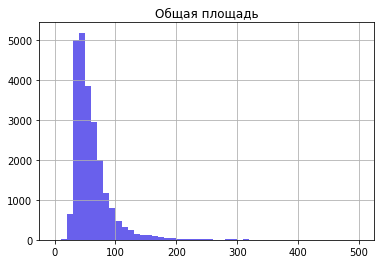

count    23565.000000
mean        60.322824
std         35.657060
min         12.000000
25%         40.000000
50%         52.000000
75%         69.700000
max        900.000000
Name: total_area, dtype: float64

Text(0.5, 1.0, 'Цена')

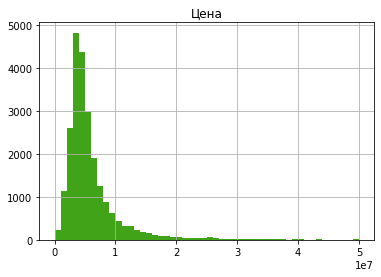

count    2.356500e+04
mean     6.540058e+06
std      1.091093e+07
min      1.219000e+04
25%      3.400000e+06
50%      4.646000e+06
75%      6.790000e+06
max      7.630000e+08
Name: last_price, dtype: float64

Text(0.5, 1.0, 'Кол-во комнат')

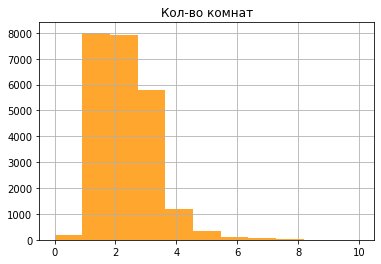

count    23565.000000
mean         2.070656
std          1.078591
min          0.000000
25%          1.000000
50%          2.000000
75%          3.000000
max         19.000000
Name: rooms, dtype: float64

Text(0.5, 1.0, 'Высота потолка')

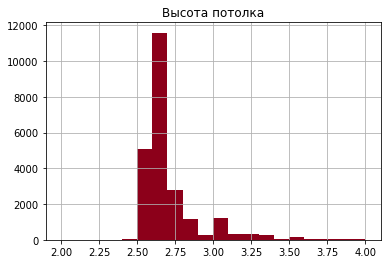

count    23565.000000
mean         2.724530
std          0.991026
min          1.000000
25%          2.600000
50%          2.650000
75%          2.700000
max        100.000000
Name: ceiling_height, dtype: float64

Text(0.5, 1.0, 'Длительность размещения объявления')

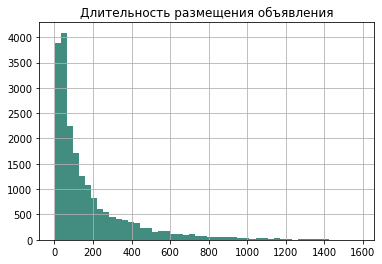

Text(0.5, 1.0, 'Длительность размещения объявления')

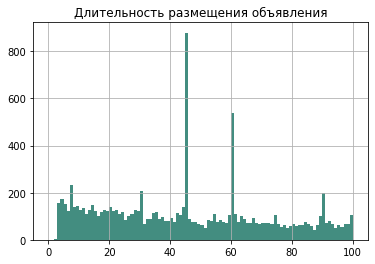

count    20394.000000
mean       180.741395
std        219.732782
min          1.000000
25%         45.000000
50%         95.000000
75%        231.000000
max       1580.000000
Name: days_exposition, dtype: float64

In [6]:
data_na_handled['total_area'].hist(bins = 50, color='#6960EC', range = (0, 500))
plt.title('Общая площадь')
plt.show()
data_na_handled['total_area'].describe()
data_na_handled['last_price'].hist(bins = 50, color='#41A317', range = (0, 50000000))
plt.title('Цена')
plt.show()
data_na_handled['last_price'].describe()
data_na_handled['rooms'].hist(bins = 11, color='#FFA62F', range = (0, 10)) 
plt.title('Кол-во комнат')
plt.show()
data_na_handled['rooms'].describe()
data_na_handled['ceiling_height'].hist(bins = 20, color='#8C001A', range = (2, 4)) 
plt.title('Высота потолка')
plt.show()
data_na_handled['ceiling_height'].describe()
data_na_handled['days_exposition'].hist(bins = 50, color='#438D80') 
plt.title('Длительность размещения объявления')
plt.show()
data_na_handled['days_exposition'].hist(bins = 100, color='#438D80', range = (0, 100)) 
plt.title('Длительность размещения объявления')
plt.show()
data_na_handled['days_exposition'].describe()
# построили гистрограммы для пяти параметров с реалистичными пределами значений
# под каждой гистограммой статистическая сводка с минимальным и максимальным значениями величин

Text(0.5, 1.0, 'total_images')

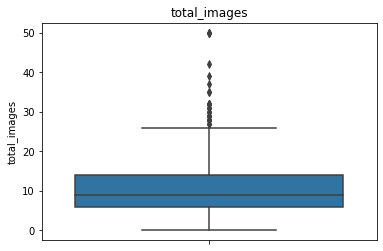

Text(0.5, 1.0, 'last_price')

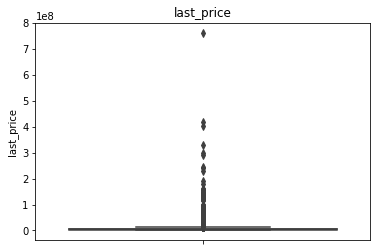

Text(0.5, 1.0, 'total_area')

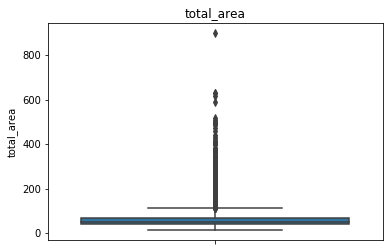

error occurred.


Text(0.5, 1.0, 'rooms')

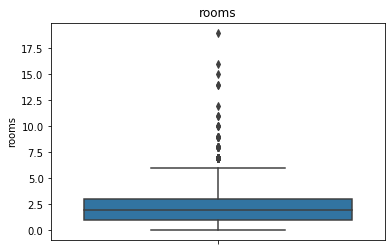

Text(0.5, 1.0, 'ceiling_height')

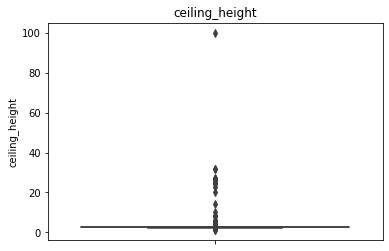

Text(0.5, 1.0, 'floors_total')

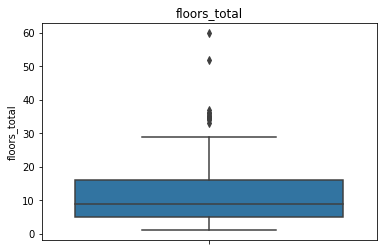

Text(0.5, 1.0, 'living_area')

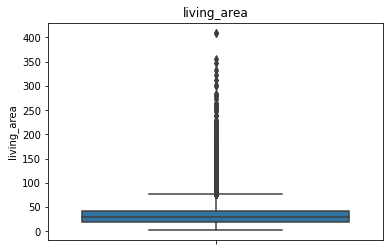

Text(0.5, 1.0, 'floor')

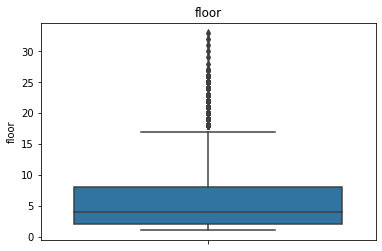

Text(0.5, 1.0, 'is_apartment')

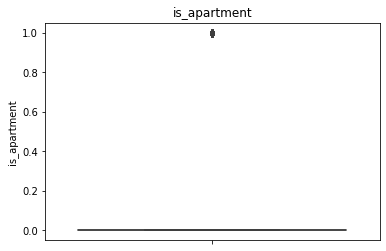

Text(0.5, 1.0, 'studio')

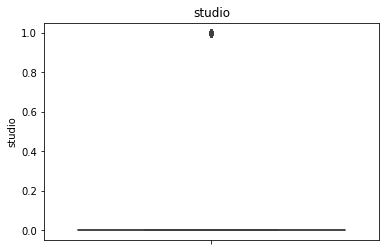

Text(0.5, 1.0, 'open_plan')

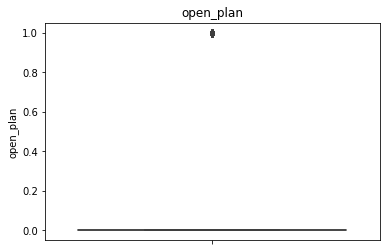

Text(0.5, 1.0, 'kitchen_area')

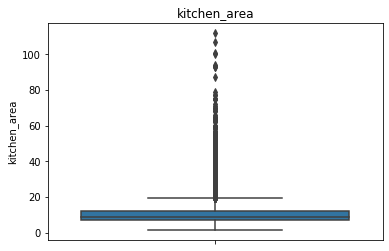

Text(0.5, 1.0, 'balcony')

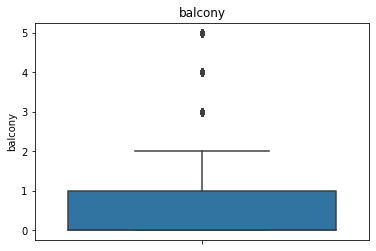

error occurred.


Text(0.5, 1.0, 'airports_nearest')

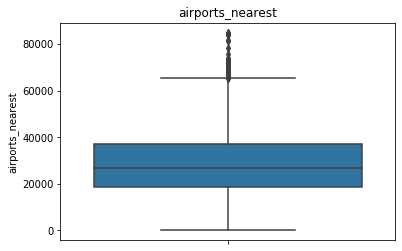

Text(0.5, 1.0, 'cityCenters_nearest')

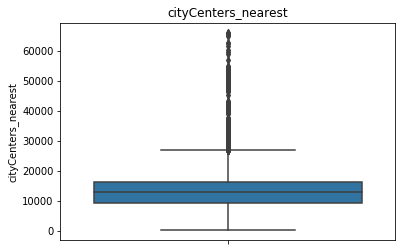

Text(0.5, 1.0, 'parks_around3000')

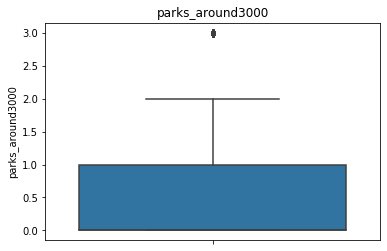

Text(0.5, 1.0, 'parks_nearest')

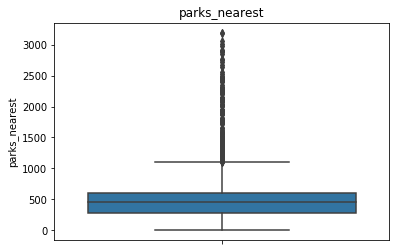

Text(0.5, 1.0, 'ponds_around3000')

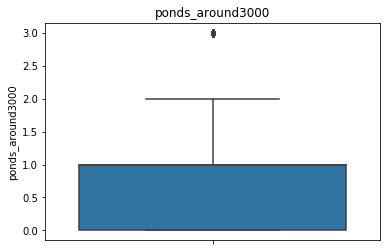

Text(0.5, 1.0, 'ponds_nearest')

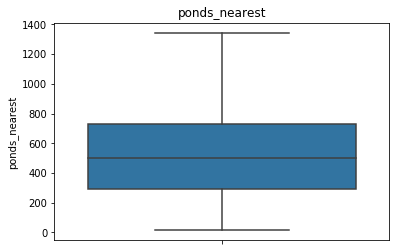

Text(0.5, 1.0, 'days_exposition')

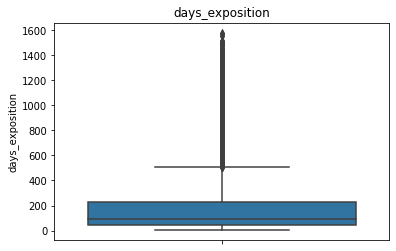

Text(0.5, 1.0, 'sq_meter_price')

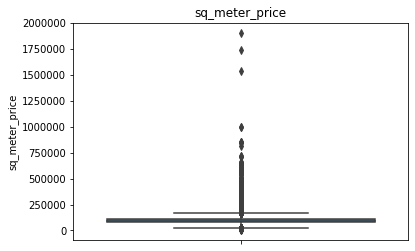

Text(0.5, 1.0, 'weekday_exposition')

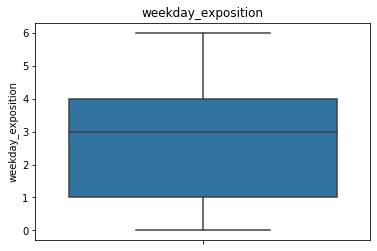

Text(0.5, 1.0, 'month_exposition')

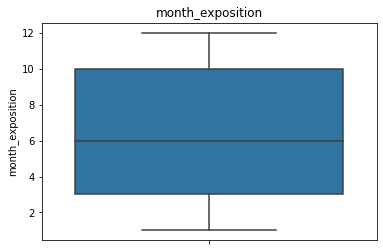

Text(0.5, 1.0, 'year_exposition')

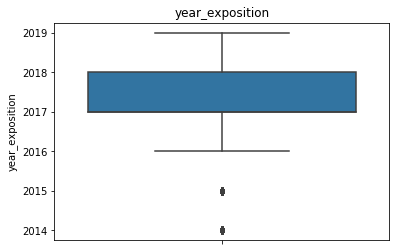

error occurred.


Text(0.5, 1.0, 'living_area_to_total_ratio')

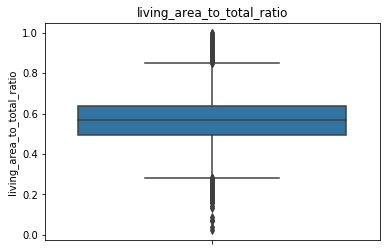

Text(0.5, 1.0, 'kitchen_area_to_total_ratio')

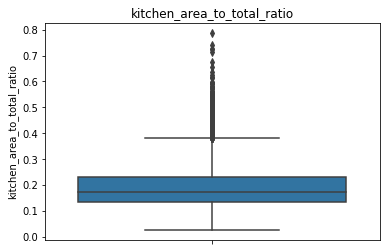

In [7]:
import seaborn as sns
for col in data_na_handled:
    try:
        sns.boxplot(y = data_na_handled[col])
        plt.title(col)
        plt.show()
    except:
        print('error occurred.')
        pass
# строим ящики с усами для всех колонок, учитывая, что у нас есть колонки с текстом и булевыми значениями
# в случае встречи с нечисловым столбцом, цикл выдает ошибку и едет к следующему столбцу

   

col_outliers = ['last_price', 'total_area', 'rooms', 'ceiling_height', 'floors_total', 'floor', 'cityCenters_nearest', 'days_exposition']
data_outlier_handled = data_na_handled.copy()
for col2 in col_outliers:
    Q1 = data_outlier_handled[col2].quantile(0.25)
    Q3 = data_outlier_handled[col2].quantile(0.75)
    IQR = Q3 - Q1
    data_outlier_handled[col2] = data_outlier_handled[col2].where(data_outlier_handled[col2] <= (Q3 + 1.5*IQR), np.nan)
    


count    2.356500e+04
mean     6.540058e+06
std      1.091093e+07
min      1.219000e+04
25%      3.400000e+06
50%      4.646000e+06
75%      6.790000e+06
max      7.630000e+08
Name: last_price, dtype: float64

count    2.151900e+04
mean     4.837115e+06
std      2.215774e+06
min      1.219000e+04
25%      3.300000e+06
50%      4.400000e+06
75%      6.000000e+06
max      1.186686e+07
Name: last_price, dtype: float64

count    23565.000000
mean        60.322824
std         35.657060
min         12.000000
25%         40.000000
50%         52.000000
75%         69.700000
max        900.000000
Name: total_area, dtype: float64

count    22326.000000
mean        54.319704
std         19.331030
min         12.000000
25%         39.400000
50%         50.000000
75%         65.500000
max        114.200000
Name: total_area, dtype: float64

count    23565.000000
mean         2.070656
std          1.078591
min          0.000000
25%          1.000000
50%          2.000000
75%          3.000000
max         19.000000
Name: rooms, dtype: float64

count    23475.000000
mean         2.047796
std          1.006547
min          0.000000
25%          1.000000
50%          2.000000
75%          3.000000
max          6.000000
Name: rooms, dtype: float64

count    23565.000000
mean         2.724530
std          0.991026
min          1.000000
25%          2.600000
50%          2.650000
75%          2.700000
max        100.000000
Name: ceiling_height, dtype: float64

count    20660.000000
mean         2.630056
std          0.084970
min          1.000000
25%          2.600000
50%          2.650000
75%          2.650000
max          2.850000
Name: ceiling_height, dtype: float64

count    23565.000000
mean        10.675875
std          6.594823
min          1.000000
25%          5.000000
50%          9.000000
75%         16.000000
max         60.000000
Name: floors_total, dtype: float64

count    23533.000000
mean        10.640930
std          6.527996
min          1.000000
25%          5.000000
50%          9.000000
75%         16.000000
max         29.000000
Name: floors_total, dtype: float64

count    23565.000000
mean         5.878124
std          4.871485
min          1.000000
25%          2.000000
50%          4.000000
75%          8.000000
max         33.000000
Name: floor, dtype: float64

count    22663.000000
mean         5.276707
std          3.870440
min          1.000000
25%          2.000000
50%          4.000000
75%          7.000000
max         17.000000
Name: floor, dtype: float64

count    18064.000000
mean     14192.656056
std       8613.348153
min        181.000000
25%       9238.000000
50%      13096.500000
75%      16285.000000
max      65968.000000
Name: cityCenters_nearest, dtype: float64

count    16342.000000
mean     12025.741035
std       5161.102668
min        181.000000
25%       8460.000000
50%      12480.000000
75%      15328.750000
max      26845.000000
Name: cityCenters_nearest, dtype: float64

count    20394.000000
mean       180.741395
std        219.732782
min          1.000000
25%         45.000000
50%         95.000000
75%        231.000000
max       1580.000000
Name: days_exposition, dtype: float64

count    18727.000000
mean       128.421637
std        121.237889
min          1.000000
25%         41.000000
50%         85.000000
75%        182.000000
max        510.000000
Name: days_exposition, dtype: float64

Text(0.5, 1.0, 'Средние цены за квартиры для категорий этажа расположения')

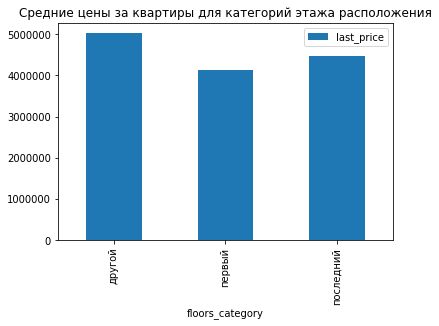

(4500000, 5000000)

Text(0.5, 1.0, 'Средние цены за квартиры по дням недели, в которые были опубликованы объявления')

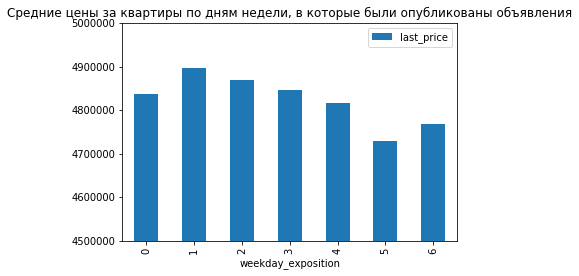

(4500000, 5000000)

Text(0.5, 1.0, 'Средние цены за квартиры по месяцам, в которые были опубликованы объявления')

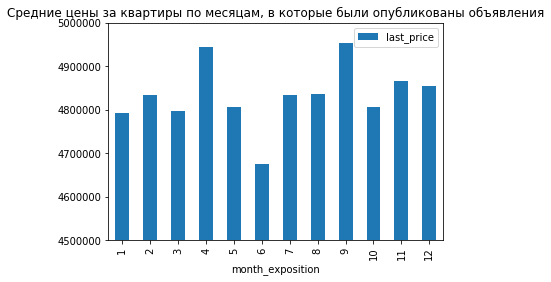

(4500000, 6000000)

Text(0.5, 1.0, 'Средние цены за квартиры по годам, в которые были опубликованы объявления')

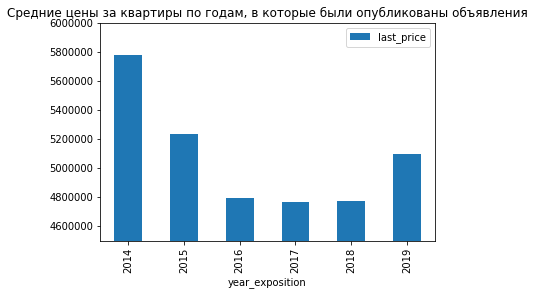

,sq_meter_price
locality_name,
Выборг,58141.489451
Всеволожск,68654.007538
Гатчина,68745.693811
Колпино,75424.150888
посёлок Шушары,78550.883827
посёлок Мурино,86040.658703
посёлок Парголово,90175.489297
деревня Кудрово,95260.393617
Пушкин,103125.373984


,last_price
cityCenters_km,
0.0,8.398000e+06
1.0,8.145277e+06
2.0,7.970519e+06
3.0,7.350003e+06
4.0,7.606618e+06
5.0,7.661225e+06
6.0,7.096569e+06
7.0,6.635321e+06
8.0,6.591220e+06


Text(0.5, 1.0, 'Средняя цена за квартиру в СПб в зависимости от удалённости от центра')

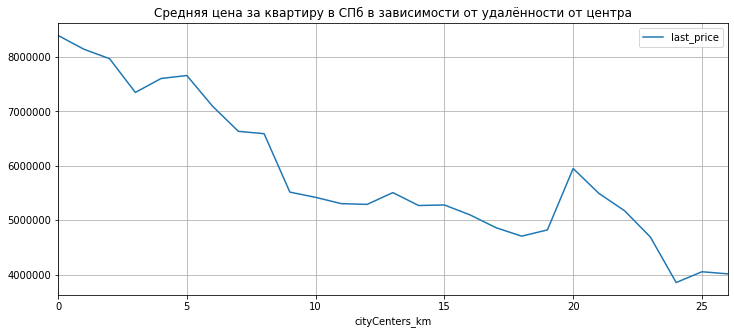

Text(0.5, 1.0, 'Средняя цена за кв.м в СПб в зависимости от удалённости от центра')

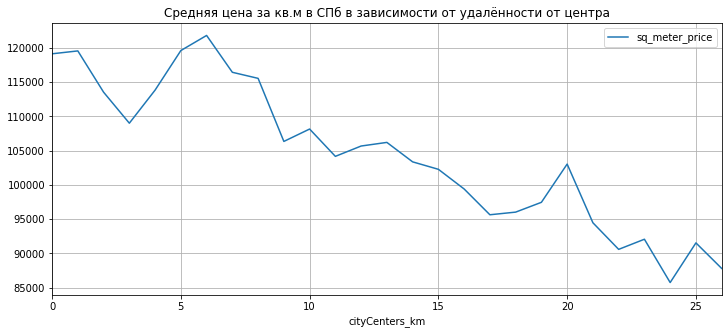

Text(0.5, 0.98, 'Цена/Расстояние от центра (слева в СПб, справа в центре СПб)')

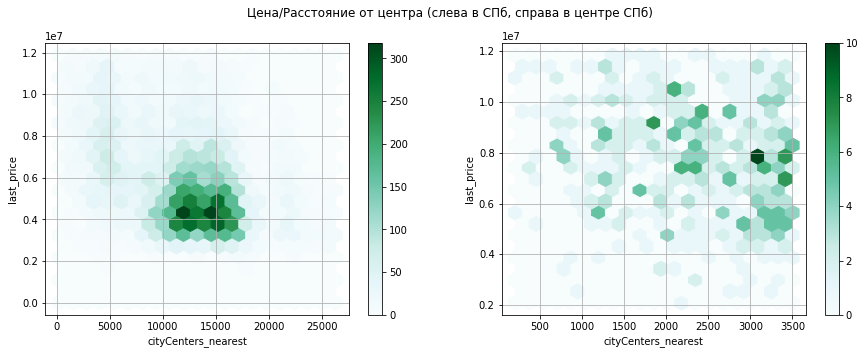

Text(0.5, 0.98, 'Цена/Кол-во дней размещения объявления (слева в СПб, справа в центре СПб)')

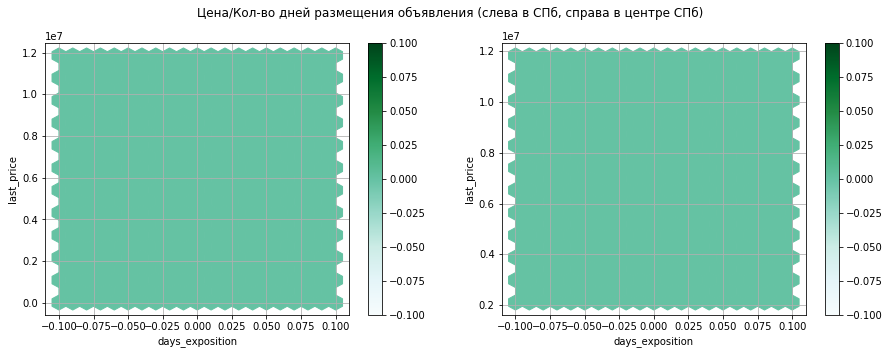

Text(0.5, 0.98, 'Цена/Кол-во комнат (слева в СПб, справа в центре СПб)')

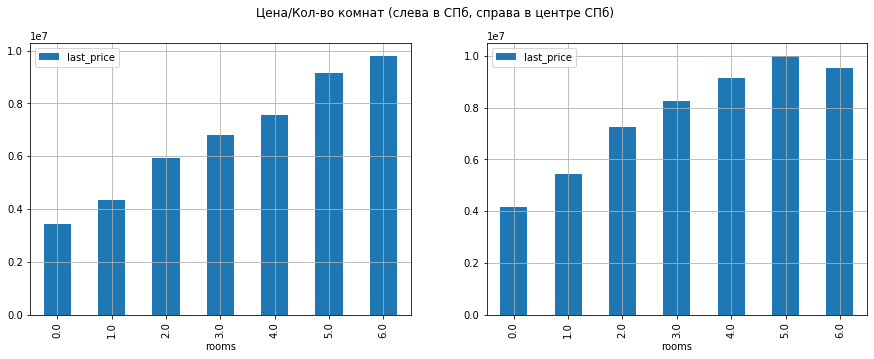

(5000000, 6000000)

(6000000, 8500000)

Text(0.5, 0.98, 'Цена/Этажность (слева в СПб, справа в центре СПб)')

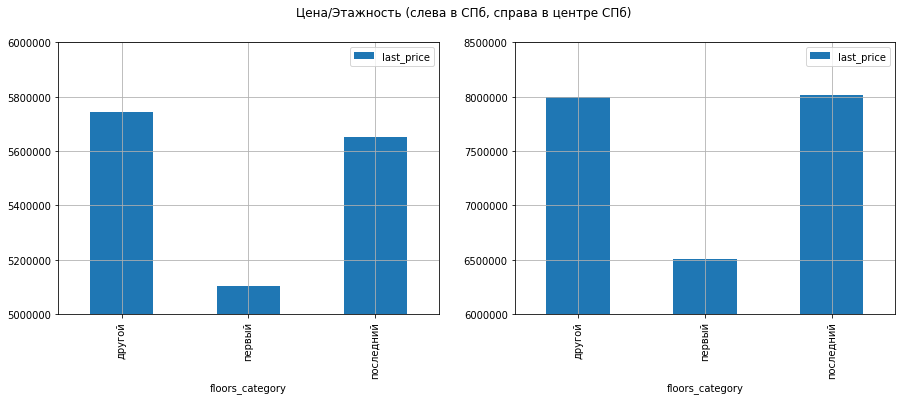

'Матрица корреляции для СПб в целом'

,last_price,rooms,cityCenters_nearest,days_exposition,total_area,ceiling_height,sq_meter_price
last_price,1.000000,0.522333,-0.366353,0.093702,0.793355,0.271594,0.373770
rooms,0.522333,1.000000,-0.282823,0.123489,0.775807,-0.023333,0.024116
cityCenters_nearest,-0.366353,-0.282823,1.000000,-0.086510,-0.268889,-0.097700,-0.313194
days_exposition,0.093702,0.123489,-0.086510,1.000000,0.126893,0.037964,0.052707
total_area,0.793355,0.775807,-0.268889,0.126893,1.000000,0.194862,0.091286
ceiling_height,0.271594,-0.023333,-0.097700,0.037964,0.194862,1.000000,0.171999
sq_meter_price,0.373770,0.024116,-0.313194,0.052707,0.091286,0.171999,1.000000


'Матрица корреляции для центра СПб'

,last_price,rooms,cityCenters_nearest,days_exposition,total_area,ceiling_height,sq_meter_price
last_price,1.000000,0.523960,-0.166720,0.069617,0.703177,0.026254,0.117045
rooms,0.523960,1.000000,-0.072778,0.116098,0.670694,0.062195,-0.036787
cityCenters_nearest,-0.166720,-0.072778,1.000000,-0.029225,-0.072627,0.027269,-0.193144
days_exposition,0.069617,0.116098,-0.029225,1.000000,0.104339,-0.106500,0.064020
total_area,0.703177,0.670694,-0.072627,0.104339,1.000000,0.058799,-0.069745
ceiling_height,0.026254,0.062195,0.027269,-0.106500,0.058799,1.000000,-0.096367
sq_meter_price,0.117045,-0.036787,-0.193144,0.064020,-0.069745,-0.096367,1.000000


'Статистики для центра СПб'

,last_price,rooms,cityCenters_nearest,days_exposition,total_area,ceiling_height,sq_meter_price
count,5.390000e+02,851.000000,877.000000,607.000000,648.000000,365.000000,8.770000e+02
mean,7.726842e+06,2.967098,2235.289624,155.080725,73.071235,2.665507,1.503307e+05
std,2.104626e+06,1.221898,883.004608,135.635280,21.822596,0.065024,1.252391e+05
min,2.100000e+06,0.000000,181.000000,3.000000,12.000000,2.500000,2.891900e+04
25%,6.150000e+06,2.000000,1500.000000,54.000000,57.000000,2.650000,9.651000e+04
50%,7.800000e+06,3.000000,2329.000000,108.000000,73.600000,2.650000,1.173910e+05
75%,9.300000e+06,4.000000,3062.000000,228.500000,91.000000,2.650000,1.518000e+05
max,1.184000e+07,6.000000,3498.000000,507.000000,114.200000,2.850000,1.736842e+06


In [8]:
for col3 in col_outliers:
    data_na_handled[col3].describe()
    data_outlier_handled[col3].describe()
# выводим статистические описания старого и нового датасетов (после обрезания усов)

#data_na_handled.corr()
#data_outlier_handled.corr()
# смотрим на матрицы корреляции для исходного и обработанного датасетов

data_outlier_handled.pivot_table(index = 'floors_category', values = 'last_price').plot(kind = 'bar')
plt.title('Средние цены за квартиры для категорий этажа расположения')
plt.show()
# Выводим гистограмму средней цены за квартиру в зависимости от категории этажности

data_outlier_handled.pivot_table(index = 'weekday_exposition', values = 'last_price').plot(kind = 'bar')
plt.ylim([4500000, 5000000])
plt.title('Средние цены за квартиры по дням недели, в которые были опубликованы объявления')
plt.show()
# Выводим гистограмму средней цены за квартиру в зависимости от дня недели, когда опубликовали объявление
# По оси У сделали срез поверху, чтобы была виднее разница.

data_outlier_handled.pivot_table(index = 'month_exposition', values = 'last_price').plot(kind = 'bar')
plt.ylim([4500000, 5000000])
plt.title('Средние цены за квартиры по месяцам, в которые были опубликованы объявления')
plt.show()
# Выводим гистограмму средней цены за квартиру в зависимости от месяца, когда опубликовали объявление
# По оси У сделали срез поверху, чтобы была виднее разница.

data_outlier_handled.pivot_table(index = 'year_exposition', values = 'last_price').plot(kind = 'bar')
plt.ylim([4500000, 6000000])
plt.title('Средние цены за квартиры по годам, в которые были опубликованы объявления')
plt.show()
# Выводим гистограмму средней цены за квартиру в зависимости от года, когда опубликовали объявление
# По оси У сделали срез поверху, чтобы была виднее разница.

top_10_localities = data_outlier_handled['locality_name'].value_counts().head(10).index.tolist()
# записали в переменную список топ-10 населённых пунктов по количеству объявлений
data_outlier_handled.query('locality_name in @top_10_localities').pivot_table(index = 'locality_name',values = 'sq_meter_price').sort_values(by = 'sq_meter_price')
# сделали сводную таблицу для топ-10 со значениями цены за кв. м, отсортировали по возрастанию

spb_data = data_outlier_handled.query('locality_name == "Санкт-Петербург"').copy()
# Отправили срез с питерскими объявлениями в отдельную переменную
spb_data['cityCenters_km'] = (spb_data['cityCenters_nearest'] / 1000).round()
# Создали столбец с расстоянием до центра в целых километрах

spb_data.pivot_table(index = 'cityCenters_km', values = 'last_price')
# сводная табличка, объявления сгруппированы по количеству км от центра,
# и посчитана средняя цена за квартиру в каждой группе

spb_data.query('(~cityCenters_km.isnull()) & (~last_price.isnull())').pivot_table(index = 'cityCenters_km', values = 'last_price').plot(grid = True, figsize = (12, 5))
plt.title('Средняя цена за квартиру в СПб в зависимости от удалённости от центра')
plt.show()
spb_data.query('(~cityCenters_nearest.isnull()) & (~last_price.isnull())').pivot_table(index = 'cityCenters_km', values = 'sq_meter_price').plot(grid = True, figsize = (12, 5))
plt.title('Средняя цена за кв.м в СПб в зависимости от удалённости от центра')
plt.show()
#pd.plotting.scatter_matrix(spb_data.query('cityCenters_km <=3')[['total_area', 'last_price', 'rooms', 'ceiling_height']], figsize=(10, 5)) 
#plt.suptitle('Попарные зависимости площади, цены, кол-ва комнат и высоты потолка друг от друга')
#plt.show()
# Матрица диаграм рассеивания почему-то стала вылезать с ошибкой, вероятно, потому что некоторые данные стали Int

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize = (15,5))
spb_data.plot(x = 'cityCenters_nearest', y = 'last_price', kind = 'hexbin', gridsize = 20, grid = True, ax = ax1)
spb_data.query('cityCenters_km <= 3').plot(x = 'cityCenters_nearest', y = 'last_price', kind = 'hexbin', gridsize = 20, grid = True, ax = ax2)
fig.suptitle('Цена/Расстояние от центра (слева в СПб, справа в центре СПб)')
plt.show()


fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize = (15,5))
spb_data.plot(x = 'days_exposition', y = 'last_price', kind = 'hexbin', gridsize = 20, grid = True, ax = ax1)
spb_data.query('cityCenters_km <= 3').plot(x = 'days_exposition', y = 'last_price', kind = 'hexbin', gridsize = 20, grid = True, ax = ax2)
fig.suptitle('Цена/Кол-во дней размещения объявления (слева в СПб, справа в центре СПб)')
plt.show()

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize = (15,5))
spb_data.pivot_table(index = 'rooms', values = 'last_price').plot(kind = 'bar', grid = True, ax = ax1)
spb_data.query('cityCenters_km <= 3').pivot_table(index = 'rooms', values = 'last_price').plot(kind = 'bar', grid = True, ax = ax2)
fig.suptitle('Цена/Кол-во комнат (слева в СПб, справа в центре СПб)')
plt.show()

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize = (15,5))
ax1.set_ylim([5000000, 6000000])
spb_data.pivot_table(index = 'floors_category', values = 'last_price').plot(kind = 'bar', grid = True, ax = ax1)
spb_data.query('cityCenters_km <= 3').pivot_table(index = 'floors_category', values = 'last_price').plot(kind = 'bar', grid = True, ax = ax2)
ax2.set_ylim([6000000, 8500000])
fig.suptitle('Цена/Этажность (слева в СПб, справа в центре СПб)')
plt.show()

'Матрица корреляции для СПб в целом'
spb_data[['last_price', 'rooms', 'cityCenters_nearest', 'days_exposition', 'total_area', 'ceiling_height', 'sq_meter_price']].corr()
"Матрица корреляции для центра СПб"
spb_data.query('cityCenters_km <= 3')[['last_price', 'rooms', 'cityCenters_nearest', 'days_exposition', 'total_area', 'ceiling_height', 'sq_meter_price']].corr()
"Статистики для центра СПб"
spb_data.query('cityCenters_km <= 3')[['last_price', 'rooms', 'cityCenters_nearest', 'days_exposition', 'total_area', 'ceiling_height', 'sq_meter_price']].describe()




(4500000, 6500000)

Text(0.5, 1.0, 'Средние цены за квартиры по дням недели, в которые были опубликованы объявления')

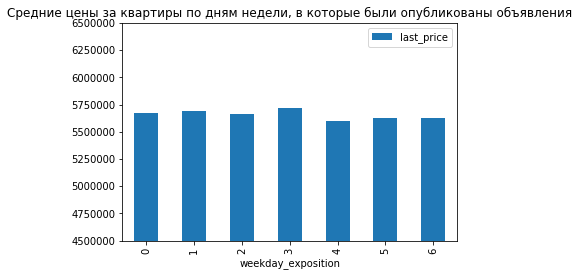

(4500000, 8500000)

Text(0.5, 1.0, 'Средние цены за квартиры по дням недели, в которые были опубликованы объявления')

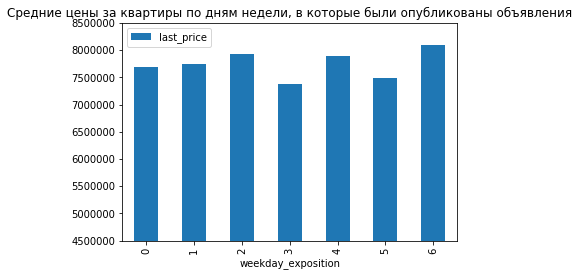

(4500000, 6500000)

Text(0.5, 1.0, 'Средние цены за квартиры по месяцам, в которые были опубликованы объявления')

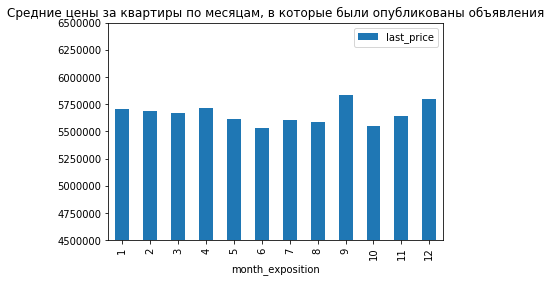

(4500000, 8500000)

Text(0.5, 1.0, 'Средние цены за квартиры по месяцам, в которые были опубликованы объявления')

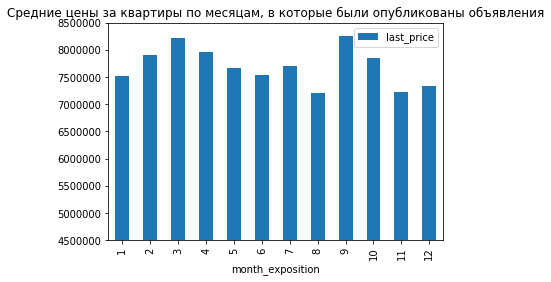

(4500000, 6500000)

Text(0.5, 1.0, 'Средние цены за квартиры по годам, в которые были опубликованы объявления')

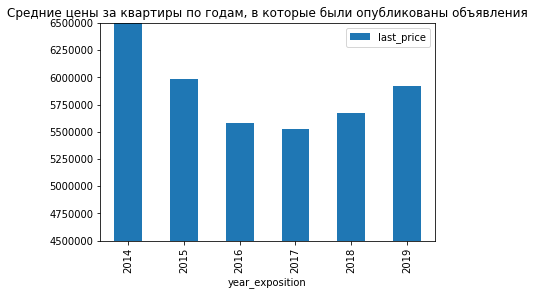

(4500000, 8500000)

Text(0.5, 1.0, 'Средние цены за квартиры по годам, в которые были опубликованы объявления')

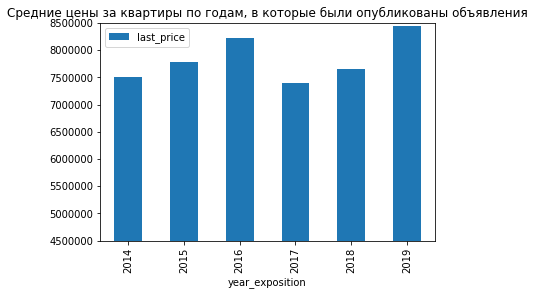

In [9]:
spb_data.pivot_table(index = 'weekday_exposition', values = 'last_price').plot(kind = 'bar')
plt.ylim([4500000, 6500000])
plt.title('Средние цены за квартиры по дням недели, в которые были опубликованы объявления')
plt.show()
# Выводим гистограмму средней цены за квартиру в зависимости от дня недели, когда опубликовали объявление
# По оси У сделали срез поверху, чтобы была виднее разница.
spb_data.query('cityCenters_km <=3').pivot_table(index = 'weekday_exposition', values = 'last_price').plot(kind = 'bar')
plt.ylim([4500000, 8500000])
plt.title('Средние цены за квартиры по дням недели, в которые были опубликованы объявления')
plt.show()
# Выводим гистограмму средней цены за квартиру в зависимости от дня недели, когда опубликовали объявление
# По оси У сделали срез поверху, чтобы была виднее разница.

spb_data.pivot_table(index = 'month_exposition', values = 'last_price').plot(kind = 'bar')
plt.ylim([4500000, 6500000])
plt.title('Средние цены за квартиры по месяцам, в которые были опубликованы объявления')
plt.show()
# Выводим гистограмму средней цены за квартиру в зависимости от месяца, когда опубликовали объявление
# По оси У сделали срез поверху, чтобы была виднее разница.
spb_data.query('cityCenters_km <=3').pivot_table(index = 'month_exposition', values = 'last_price').plot(kind = 'bar')
plt.ylim([4500000, 8500000])
plt.title('Средние цены за квартиры по месяцам, в которые были опубликованы объявления')
plt.show()
# Выводим гистограмму средней цены за квартиру в зависимости от месяца, когда опубликовали объявление
# По оси У сделали срез поверху, чтобы была виднее разница.

spb_data.pivot_table(index = 'year_exposition', values = 'last_price').plot(kind = 'bar')
plt.ylim([4500000, 6500000])
plt.title('Средние цены за квартиры по годам, в которые были опубликованы объявления')
plt.show()
# Выводим гистограмму средней цены за квартиру в зависимости от года, когда опубликовали объявление
# По оси У сделали срез поверху, чтобы была виднее разница.
spb_data.query('cityCenters_km <=3').pivot_table(index = 'year_exposition', values = 'last_price').plot(kind = 'bar')
plt.ylim([4500000, 8500000])
plt.title('Средние цены за квартиры по годам, в которые были опубликованы объявления')
plt.show()
# Выводим гистограмму средней цены за квартиру в зависимости от года, когда опубликовали объявление
# По оси У сделали срез поверху, чтобы была виднее разница.

#### Исследовательский анализ датасета
##### Площадь, цена, число комнат, высота потолков. 
1. Гистограмма по общей площади стремится к нормальному распределению, с некоторым сдвигом пика влево. Это довольно правдоподобно, учитывая, что квартиры в 1 и 2 комнаты продают чаще многокомнатных. Выбросы есть, но их не очень много, среднее довольно близко к медиане.
2. Распределение цен на квартиры тоже похоже на нормальное, с длинным хвостом справа. Здесь выбросы сильно влияют на статистические характеристики, что не удивительно, максимальная цена аж 763 миллиона. Основная часть объявлений относится к ценовой категории 4-5 млн, сюда как раз и попадают наиболее продаваемые небольшие квартиры.
3. Эта же тенденция потверждается и на гистограмме количеств комнат: 1-2 комнаты - самый популярный тип жилья на рынке недвижимости. 
4. Для высоты потолка вышло интересное распределение. Есть что-то, похожее на нормальное, но потом идет еще маленький пик на 3 метрах. Отсутствие плавности в правой части можно объяснить тем, что в разные годы строительства были общеприняты те или нормы по высоте потолков, и возможно, высоты 2.9 м просто не было среди этих стандартов, поэтому они - редкость. В целом, выглядит тоже правдоподобно, квартиры с 2.6-метровыми потолками у нас в топе. Есть интересное значение в 100 метров - очевидный и невероятный выброс.


##### Время продажи квартиры.
Если увеличивать количество корзин и масштаб для пиковых значений, видим выдающиеся столбики, особенно выдаётся столбик в районе 45 дней, таких объявлений почти 900 штук! Единственный вариант, который мог бы как-то объяснить такие аномалии и пришёл мне в голову - что 7,30, 45, 60, 90 дней - это какие-то пределы, после которых цена на квартиру может поменяться в невыгодную сторону. Например, если есть фиксация цены на 45 дней, в последний день старой цены происходят ажиотаж и импульсивные покупки.


Если смотреть по медиане, обычно на продажу уходит три месяца. Среднее же время при этом составляет полгода, это очень большая разница, очевидно, что выпадающие значения имеют сильное влияние на среднее. 

Есть квартира, которую купили за один день - питерская двушка по хорошей цене, почему бы и нет. Вопрос только, реально ли утрясти всю бюрократию продажи за один день. Есть квартира, которую продавали 4 с лишним года, это долговато, но таких квартир довольно много. Возможно эти счастливчики собрали комбо антипродажных причин: завысили цену, продают квартиру на 1 этаже, выложили мало или плохие фото и прочие неприятности. Те же, кто продавал за неделю и быстрее - собрали это же комбо наоборот. Ну, или очень хороший риелтор помог. Посмотрим на ящики с усами, вдруг подскажут что-нибудь.


##### Редкие и выбивающиеся значения.

Построим для всех числовых данных ящики с усами, отберём те, у которых нужно убрать выбросы и редкие значения, те, которые нам понадобятся для исследования. Уберём выбросы у общей площади, расстояния до центра, этажей, количеств комнат, высот потолков, дней размещения объявления, стоимости квартиры. 
После обрезания выбросов у всех данных уменьшилась разница между медианой и средним. И во всех колонках с большими числами значительно уменьшилось стандартное отклонение, мы сгладили разброс данных.


##### Что влияет на стоимость квартиры?

Построив матрицу корреляций, можно выявить самые сильные факторы, влияющие на цену. Надеюсь, ничего нелогичного не заметим. Итак, на цену ожидаемо влияют площади (общая, жилая, кухни, и вытекающая из этого стоимость кв.м.) и количество комнат.


У всех картографических данных, обозначающих расстояния до полезных объектов, корреляция со знаком минус, пусть и близкая к нулю: дальше парк - ниже цена.

После обработки некоторых выбросов, коэффициенты ожидаемых корреляций немного подросли. Можно осторожно надеяться, что "обрезание" было сделано не зря.


Посмотрим, играет ли роль расположение квартиры на том или ином этаже. Результат оправдал ожидания: первый этаж любят меньше всего, последний на втором месте, но им обоим предпочитают промежуточные этажи, так как у них отсутствуют такие недостатки, как близость подвала/магазина внизу и возможно протекающей крыши/чердака. Потому и цены выше.


Посмотрим теперь, а вдруг цена зависит от того, в какой день недели, месяц или год опубликовали объявление? 
- Понедельник - день тяжёлый, как и тяжелы бывают кошельки тех, кто начинает продавать квартиру с понедельника. В пятницу же цены спадают, это точно как-то связано с коцном рабочей недели.. Продают недельные остатки подешевле? Или может, там больше предложений перед выходными, и все пытаются продать по привлекательной цене.
- Апрель и Сентябрь - самые дорогие месяцы. Возможно, потому что зимой и летом продажей занимаются не очень активно, и к весне-осени остаётся мало предложений, люди готовы покупать и подороже.
- 2014 год - год серьёзного экономического кризиса, отсюда и сильное падение цен к 2016 году, к 2019 году ситуация со спросом стабилизовалась, цены подняли.


##### Топ-10 населённых пунктов в объявлениях. 

Мы уже выискивали топ-10 населённых пунктов в самом начале проекта, чтобы понять, нет ли дубликатов этих названий. 
Теперь посмотрим, дорого ли в них поселиться. Ожидаемый максимум за квадратный метр принадлежит Санкт-Петербургу, далее следует город Пушкин, что интересно, ведь, в отличие от идущих следом за ним посёлков и деревень, он находится в некотором отдалении от города. Там дворец и школа Пушкина, видимо, они там и решают все вопросы недвижимости. Дешевле всех квадратный метр среди этих десяти - в городе Выборге. Он очень далеко от Питера, но является довольно крупным городом, вот и затесался в топ-10 среди ближайших деревень.

##### Санкт-Петербург. С чего начинается центр?

Посмотрим на среднюю цену за квартиру на каждом километре, удаляясь от центра. Вполне закономерное убывание средней цены с нуля километров и далее, но есть некоторый прирост в районе 20 км от центра. Возможно, это такая экологическая зона с малоэтажным жильём комфорт-класса.

Определим, что считать центром. Есть очень явный провал в цене на уровне 3 км от центра, но при этом дальше график прилично вырастает. Питер - очень неоднозначный, несимметричный и растянутый город, придётся опереться на свой здравый смысл и этот переломный момент в графике. Можно было бы выбрать 5-6 км от центра, где цена начинает спадать сильнее, но это слишком далеко с обывательской точки зрения. Там точно расположены даже не околоцентральные районы.
Пусть будет 3 км.



#####  Каковы особенности жилья в центре Петербурга?

Посмотрим на матрицу диаграмм рассеивания для цены, общей площади, числа комнат и высоты потолков.

- На матрице площадь-цена видно, что меньшая площадь (50-60 квадратов) менее вариативна по цене, по сравнению с большими (ближе к 100 кв м). Данные более кучные. Много представлено вариантов с большой площадью, центр всё-таки.
- Площадь-комнаты. Видно, что двушки бывают всякие. 3 и 4 комнаты примерно одинаково разбросаны по площади. Многокомнатные квартиры ожидаемо на верхушке значений площади.
- Площадь-потолки. Вертикальные полосочки подтверджают, что есть некий набор высот потолка, который наиболее распространён в наших домах, и есть самая популярная высота в примерно 2.65 метра, очень много квартир самых разных площадей.
- Цена-комнаты. Интересно, что двушки могут догонять многокомнатные квартиры по цене. И даже есть немного таких же дорогих однушек. 

Сравним некоторые зависимости для центра и для города в целом. Матрицы корреляции.

- Цена/количество комнат. Цена растёт с увеличением количества комнат, но не линейно: разница между однушкой и двушкой заметнее разницы между 3-хкомнатной и 4-хкомнатной квартирами. Это верно для всех квартир, не только в СПб. Есть некоторое отличие центра - там 5-комнатные в среднем дороже 6-комнатных. Возможно, это какие-то аномалии вмешались в среднее после обрезания данных до центра.
- Цена/этажность. Первый этаж сильно дешевле и в городе и в его центре. А вот последний в центре в среднем стоит столько же, сколько и другие этажи. Может, дело в питерских крышах в центре, они - визитная карточка города, и добавляют к цене.
- Цена/удалённость от центра. Странно смотреть на удалённость от центра в центре, наверное, уже замылилась голова у студента-аналитика. На диаграмме всего города видно, что самое большое количество объявлений в районе 12-15 км от центра, по цене 4-5 млн. Возможно, это самые густонаселённые спальные районы, там много многоэтажек с типовыми квартирами. На "центральной" же диаграме видно, что объявления в основном с "окраины" этого самого центра. Это можно объяснить тем, что в самом центральном центре уже почти не осталось жилья, всё переделывают под отели и офисы.
- Цена/кол-во дней размещения объявления. Если смотреть по городу в целом, быстрее (в пределах 1-2 месяцев) продаются эконом-варианты по 4 млн, и таких объявлений больше всего. В центре всё продаётся медленнее, по большей части в течение 3х месяцев - 100 дней. На матрице корреляции видно, что такой фактор, как дата размещения (=длительность размещения) не очень коррелирует с ценой, то есть итоговые цены, когда бы изначально не опубликовали объявление, примерно одни и те же.
- Цена за квадратный метр сильнее влияет на питерские цены в целом, в отличие от центра города.
- Высота потолков - довольно весомый фактор для общегородских цен, в центре корреляция практически нулевая - там наверное везде высокие потолки)


Дни недели, месяцы и годы.

- По дням недели в городе в целом разброса не наблюдается, есть интересные пики на вт, чт, сб для центра города..
- По месяцам любопытно, что апрельский пик цен почти не выражен у города в целом, и явно наблюдается для центра
- По годам у города в целом всё идёт плавно, тогда как центральные квартиры в 2016 году взлетели в цене












In [10]:
spb_data.columns

Index(['total_images', 'last_price', 'total_area', 'first_day_exposition',
       'rooms', 'ceiling_height', 'floors_total', 'living_area', 'floor',
       'is_apartment', 'studio', 'open_plan', 'kitchen_area', 'balcony',
       'locality_name', 'airports_nearest', 'cityCenters_nearest',
       'parks_around3000', 'parks_nearest', 'ponds_around3000',
       'ponds_nearest', 'days_exposition', 'sq_meter_price',
       'weekday_exposition', 'month_exposition', 'year_exposition',
       'floors_category', 'living_area_to_total_ratio',
       'kitchen_area_to_total_ratio', 'cityCenters_km'],
      dtype='object')

### Шаг 5. Общий вывод

Стоимость квартиры - очень сложный многофакторный объект. Главное, что удалось вычленить в качестве очень-очень ценообразующих параметров: количество комнат, площадь квартиры, в качестве параметров, влияющихна цену чуть слабее: высота потолков, тип этажа (в центре это первый или все остальные) и удалённость от центра города.


### Чек-лист готовности проекта

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  открыт файл
- [x]  файлы изучены (выведены первые строки, метод info())
- [x]  определены пропущенные значения
- [x]  заполнены пропущенные значения
- [x]  есть пояснение, какие пропущенные значения обнаружены
- [x]  изменены типы данных
- [x]  есть пояснение, в каких столбцах изменены типы и почему
- [x]  посчитано и добавлено в таблицу: цена квадратного метра
- [x]  посчитано и добавлено в таблицу: день недели, месяц и год публикации объявления
- [x]  посчитано и добавлено в таблицу: этаж квартиры; варианты — первый, последний, другой
- [x]  посчитано и добавлено в таблицу: соотношение жилой и общей площади, а также отношение площади кухни к общей
- [x]  изучены следующие параметры: площадь, цена, число комнат, высота потолков
- [x]  построены гистограммы для каждого параметра
- [x]  выполнено задание: "Изучите время продажи квартиры. Постройте гистограмму. Посчитайте среднее и медиану. Опишите, сколько обычно занимает продажа. Когда можно считать, что продажи прошли очень быстро, а когда необычно долго?"
- [x]  выполнено задание: "Уберите редкие и выбивающиеся значения. Опишите, какие особенности обнаружили."
- [x]  выполнено задание: "Какие факторы больше всего влияют на стоимость квартиры? Изучите, зависит ли цена от квадратного метра, числа комнат, этажа (первого или последнего), удалённости от центра. Также изучите зависимость от даты размещения: дня недели, месяца и года. "Выберите 10 населённых пунктов с наибольшим числом объявлений. Посчитайте среднюю цену квадратного метра в этих населённых пунктах. Выделите населённые пункты с самой высокой и низкой стоимостью жилья. Эти данные можно найти по имени в столбце '*locality_name'*. "
- [x]  выполнено задание: "Изучите предложения квартир: для каждой квартиры есть информация о расстоянии до центра. Выделите квартиры в Санкт-Петербурге (*'locality_name'*). Ваша задача — выяснить, какая область входит в центр. Создайте столбец с расстоянием до центра в километрах: округлите до целых значений. После этого посчитайте среднюю цену для каждого километра. Постройте график: он должен показывать, как цена зависит от удалённости от центра. Определите границу, где график сильно меняется — это и будет центральная зона. "
- [x]  выполнено задание: "Выделите сегмент квартир в центре. Проанализируйте эту территорию и изучите следующие параметры: площадь, цена, число комнат, высота потолков. Также выделите факторы, которые влияют на стоимость квартиры (число комнат, этаж, удалённость от центра, дата размещения объявления). Сделайте выводы. Отличаются ли они от общих выводов по всему городу?"
- [x]  в каждом этапе есть выводы
- [x]  есть общий вывод